# 1.1 核平滑方法

参考文章:https://blog.csdn.net/xfijun/article/details/105942000

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
file = pd.read_csv('mcycle.csv')
file


NameError: name 'x' is not defined

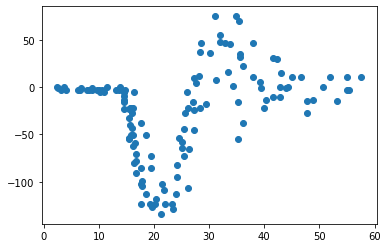

In [5]:
x = file['times'] 
y = file['accel'] 
plt.scatter(x,y)

In [4]:
def kernel_regression(x, h, h0):
    weight_e = lambda t:  (1-t**2)*3/4 #e核函数
    weight_t = lambda t:  (1-t**3)**3 #t核函数
    
    num = len(x)
    y_rec_e = np.zeros(num)
    y_rec_t = np.zeros(num)
    y_rec_g = np.zeros(num)
    for i in range(num):
        dist = np.abs(x-x[i])/h  #核函数中的t
        # epanechnikov
        w_e = weight_e(dist)*np.where(dist<=1,1,0) #控制窗宽？             
        y_rec_e[i] = np.sum(y*w_e)/np.sum(w_e)#核回归函数
        # tri-cube
        w_t = weight_t(dist)*np.where(dist<=1,1,0) 
        y_rec_t[i] = np.sum(y*w_t)/np.sum(w_t)
    
    # gaussian kernel    
    gaussian_kernel = lambda d,h: np.exp(-dist**2/(2*(h**2)))#/(np.sqrt(2*np.pi)*h)
    for i in range(num):
        dist = np.abs(x-x[i])
        w = gaussian_kernel(dist,h0)
        y_rec_g[i] = np.sum(y*w)/np.sum(w)        
    return y_rec_g, y_rec_e, y_rec_t,  y

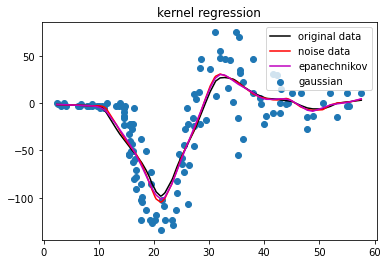

In [5]:
    h = 5
    h0 = 2
    y_rec_g, y_rec_e, y_rec_t, y = kernel_regression(x,h,h0)
    plt.scatter(x,y)
    plt.plot(x,y_rec_e,'k')
    plt.plot(x,y_rec_t,'r')
    plt.plot(x,y_rec_g,'m')    
    plt.legend(labels=['original data','noise data','epanechnikov','gaussian'],loc='upper right')
    plt.title('kernel regression') 
    plt.show()

# 

```py
for i in range(1,5):#左闭右开的区间
    print(i)
```

# 1.2 局部多项式回归

In [1]:
#导入库
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#导入文件数据
file = pd.read_csv('mcycle.csv')
x = file['times'] 
y = file['accel']

In [3]:
#求R方函数，评价模型回归效果
def rsq(y,y_pred):
    ssr = 0
    for i in range(len(x)):
        ssr = ssr+(y[i]-y_pred[i])**2
    ssr = ssr/len(x)
    print("ssr=%.3f"%ssr)
    sst = 0
    for i in range(len(x)):
        sst = sst+(y[i]-np.mean(y))**2
    sst = sst/len(x)
    print("sst=%.3f"%sst)
    return 1-ssr/sst 

In [4]:
def mse(y,y_pred):
    mse = 0
    for i in range(len(x)):
        mse = mse+(y[i]-y_pred[i])**2
    mse = mse/len(x)
    return mse

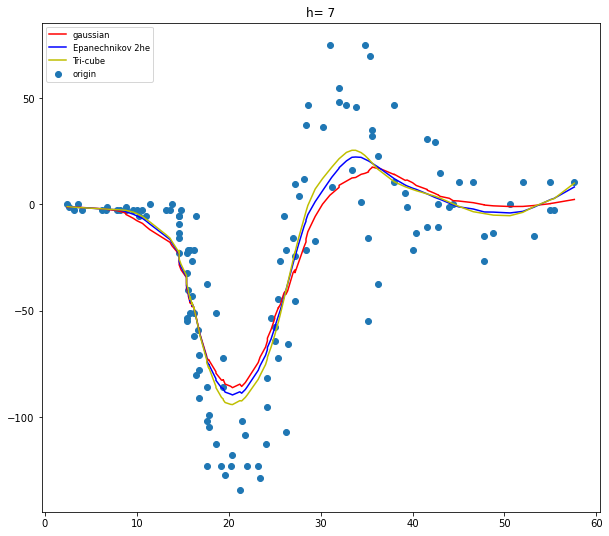

使用R^2评估模型好坏:

**************************************************
ssr=697.449
sst=2317.464
rsq_g=0.699046408497
**************************************************
ssr=615.886
sst=2317.464
rsq_e=0.734241512805
**************************************************
ssr=569.044
sst=2317.464
rsq_t=0.754453833680
**************************************************
使用mse评估模型好坏:

mse_g= 697.4491099628567
**************************************************
mse_e= 615.8857232240154
**************************************************
mse_t= 569.0443975077528


In [10]:
#基于多项式模型的加权最小二乘法
def weighted_least_squares(y,x,M,W): #加权最小二乘法 ，利用公式求出theta
    design_matrix = np.asmatrix(np.ones(len(x))).T##初始化设计矩阵 。np.ones(shape, dtype=None, order='C')函数返回给定形状和数据类型的新数组，其中元素的值设置为1，行优先(‘C’)还是列优先(‘F’)
    for i in range(1,M+1):
        arr = np.asmatrix(np.power(x,i)).T
        design_matrix  = np.concatenate((design_matrix ,arr),axis=1)    
    coef = (design_matrix.T*W*design_matrix).I*(design_matrix.T*W*(np.asmatrix(y).T))    #系数
    return (np.asarray(coef)).T

def local_polynomial_kernel_regression(y,x,M,width,h):#M是多项式最高次数
    kernel_g = lambda t,h: np.exp(-(t**2/2))#)#使用lambda匿名函数定义三种核函数
    kernel_e = lambda t,h:(3/4)*(1-(t)**2)
    kernel_t = lambda t,h:(1-((abs(t)**3)))**3
    coef_g= np.zeros((len(x), M+1))
    coef_t= np.zeros((len(x), M+1))  
    coef_e= np.zeros((len(x), M+1))  
    for i in range(len(x)):
        local_y = y[max(0,i-width):min(len(x),i+width)] 
        local_x = x[max(0,i-width):min(len(x),i+width)]
        dist = np.abs(x-x[i])/h
        w_g = kernel_g(dist,h)#计算x_i关于所有x的核函数，作为权值
        w_e = kernel_e(dist,h)*np.where(dist<=1,1,0)#E核和T核比较特殊，满足dist<=1乘1,否则乘0           
        w_t = kernel_t(dist,h)*np.where(dist<=1,1,0) 
        local_weight_g = w_g[max(0,i-width):min(len(x),i+width)]#找出x_i邻域内个点关于x_i的核函数，权值
        local_weight_e = w_e[max(0,i-width):min(len(x),i+width)]
        local_weight_t = w_t[max(0,i-width):min(len(x),i+width)]
        W_g = np.diag(local_weight_g)#将权值对角化，np.diag()如果输入是二维数组，返回k位置的对角线。如果是一维数组，返回一个v作为k位置对角线的二维数组。默认为0，可选参数。对角线的位置，大于零位于对角线上面，小于零则在下面。
        W_e = np.diag(local_weight_e)
        W_t = np.diag(local_weight_t)
        #print()
        coef_g[i] = weighted_least_squares(local_y,local_x,M,W_g)#求出系数
        coef_e[i] = weighted_least_squares(local_y,local_x,M,W_e)
        coef_t[i] = weighted_least_squares(local_y,local_x,M,W_t)
        for j in range(M+1):
            y_pre_g[i]=y_pre_g[i]+coef_g[i][j]*(x[i]**j)
            y_pre_e[i]=y_pre_e[i]+coef_e[i][j]*(x[i]**j)
            y_pre_t[i]=y_pre_t[i]+coef_t[i][j]*(x[i]**j)
    return y_pre_g,y_pre_e,y_pre_t,coef_g,coef_e,coef_t

if __name__ == '__main__': 
    plt.figure(figsize=(10,9))
    plt.scatter(x,y)
    y_pre_g = np.zeros(len(x))
    y_pre_t = np.zeros(len(x))
    y_pre_e = np.zeros(len(x))
    h=7
    y_pred_g,y_pred_e,y_pred_t,coef_g,coef_e,coef_t = local_polynomial_kernel_regression(y,x,1,20,h)
    plt.plot(x,y_pred_g,'r')
    plt.plot(x,y_pred_e,'b')
    plt.plot(x,y_pred_t,'y')
    plt.legend(labels=['gaussian','Epanechnikov 2he','Tri-cube','origin'],loc='upper left',fontsize='small')#plt.legend()函数的作用是给图像加图例。loc设置位置，fontsize设置字体大小，title=设置图例标题
    plt.title('h= %d'% h)
    plt.show()
    print("使用R^2评估模型好坏:\n")
    print('*'*50)
    print("rsq_g=%.12f"%rsq(y,y_pred_g))
    print('*'*50)
    print("rsq_e=%.12f"%rsq(y,y_pred_e))
    print('*'*50)
    print("rsq_t=%.12f"%rsq(y,y_pred_t))
    print('*'*50)
    
    print("使用mse评估模型好坏:\n")
    print("mse_g=",mse(y,y_pre_g))
    print('*'*50)
    print("mse_e=",mse(y,y_pre_e))
    print('*'*50)
    print("mse_t=",mse(y,y_pre_t))
    